In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline

In [64]:
boston = load_boston()

In [65]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [66]:
indices = []

for i in range(len(boston["feature_names"])):
    indices.append(i)

In [67]:
columns = np.array(list(zip(boston["feature_names"], indices)))

In [68]:
print(columns)

# print out the column indices so it's easier to refer to

[['CRIM' '0']
 ['ZN' '1']
 ['INDUS' '2']
 ['CHAS' '3']
 ['NOX' '4']
 ['RM' '5']
 ['AGE' '6']
 ['DIS' '7']
 ['RAD' '8']
 ['TAX' '9']
 ['PTRATIO' '10']
 ['B' '11']
 ['LSTAT' '12']]


In [69]:
boston["target"][0:5]

array([ 24. ,  21.6,  34.7,  33.4,  36.2])

## Preprocessing

In [70]:
boston_X = boston.data[:, (4, 6, 8, 10, 12)]
# Select out just a few of the features 
# NOX      nitric oxides concentration (parts per 10 million)
# AGE      proportion of owner-occupied units built prior to 1
# RAD      index of accessibility to radial highways
# PTRATIO  pupil-teacher ratio by town
# LSTAT    % lower status of the population

In [71]:
boston_y = boston["target"]

In [72]:
combined = np.column_stack([boston_X, boston_y])

In [73]:
dataset = pd.DataFrame(combined).sample(frac = 1).reset_index(drop = True)

In [74]:
dataset.columns = ["NOX", "AGE", "RAD", "PTRATIO", "LSTAT", "TARGET"]

In [75]:
dataset.head()

,NOX,AGE,RAD,PTRATIO,LSTAT,TARGET
0,0.624,98.9,4.0,21.2,12.60,19.2
1,0.437,42.3,4.0,16.0,10.40,21.7
2,0.624,94.7,4.0,21.2,18.34,14.3
3,0.605,93.0,5.0,14.7,9.81,25.0
4,0.489,52.5,4.0,18.6,10.97,24.4


In [76]:
X = np.array(dataset.iloc[:, :-1]) # everything except for TARGET
y = np.array(dataset["TARGET"])

In [77]:
print(X.shape)

(506, 5)


In [78]:
print(y.shape)

(506,)


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [80]:
print(X_train.shape)

(354, 5)


In [81]:
print(y_train.shape)

(354,)


In [82]:
print(X_test.shape)

(152, 5)


In [83]:
print(y_test.shape)

(152,)


In [84]:
naive_model = Ridge()

In [85]:
naive_model

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [86]:
scores = cross_val_score(naive_model, X, y, cv = 3) # 3 folds

In [87]:
print("Scores:", scores)

Scores: [ 0.62981876  0.60889134  0.61439019]


In [88]:
print("Mean Scores:", np.mean(scores))

Mean Scores: 0.61770009678


In [89]:
# fit the model with training data
naive_model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [90]:
# predict 
naive_predictions = naive_model.predict(X_test)
print(X_test.shape, naive_predictions.shape)

(152, 5) (152,)


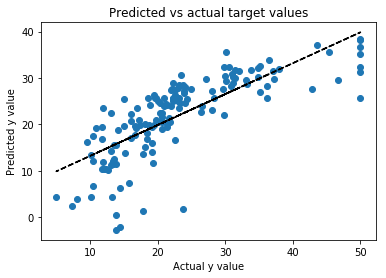

In [91]:
plt.scatter(y_test, naive_predictions)
z = np.polyfit(y_test, naive_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Predicted y value")
plt.plot(y_test, p(y_test), "k--")

In [92]:
naive_model.score(X_test, y_test)

0.5662108379730233

## Issues with the above model
Without outlier reduction and/or anomaly detection, the performance is pretty bad. Let's do ths again with outlier reduction.

## Isolation Forest

In [93]:
from sklearn.ensemble import IsolationForest

In [94]:
iso_forest = IsolationForest(n_estimators = 250, bootstrap = True)

In [95]:
iso_forest.fit(X, y)

IsolationForest(bootstrap=True, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=250, n_jobs=1, random_state=None,
        verbose=0)

In [96]:
# get outliers
iso_outliers = iso_forest.predict(X) == -1

In [97]:
iso_outliers[0:10]

array([False, False, False, False, False, False,  True, False, False, False], dtype=bool)

In [98]:
# remove outliers from the dataset

X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]

In [99]:
X_train_iso, X_test_iso, y_train_iso, y_test_iso = train_test_split(X_iso, y_iso, test_size = 0.3)

In [100]:
print(X_train_iso.shape) # new X_train without outliers

(318, 5)


In [101]:
print(X_train.shape) # old X_train with outliers

(354, 5)


In [102]:
iso_model = Ridge()
iso_model.fit(X_train_iso, y_train_iso)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [103]:
iso_scores = cross_val_score(estimator = iso_model, X = X_test_iso, y = y_test_iso)

In [104]:
print("Iso Scores:", iso_scores)

Iso Scores: [ 0.63854123  0.48567148  0.52543692]


In [105]:
print("Mean Iso Scores", np.mean(iso_scores))

Mean Iso Scores 0.549883210488


In [106]:
# predict 
iso_predictions = iso_model.predict(X_test)

In [107]:
iso_predictions[0:10]

array([ 31.12664096,  10.41916417,  23.41828152,  15.2256998 ,
        30.56728762,  32.79090315,  13.47966926,  34.86944875,
        31.5604568 ,  11.98158673])

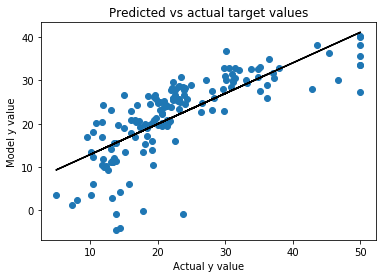

In [108]:
plt.scatter(y_test, iso_predictions)
z = np.polyfit(y_test, iso_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), "k-")

In [109]:
iso_model.score(X_test_iso, y_test_iso)

0.67935299752306411

## OneClassSVM

In [110]:
from sklearn.svm import OneClassSVM

In [111]:
svm = OneClassSVM(kernel = "rbf")

In [112]:
svm.fit(X, y)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [113]:
svm_outliers = svm.predict(X) == -1
svm_outliers[0:10]

array([False,  True,  True,  True,  True, False, False,  True,  True, False], dtype=bool)

In [114]:
# remove outliers
X_svm = X[~svm_outliers]
y_svm = y[~svm_outliers]

In [115]:
print(X_svm.shape) # without outliers

(268, 5)


In [116]:
print(X.shape) # with outliers

(506, 5)


In [117]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size = 0.3)

In [118]:
svm_model = Ridge().fit(X_train_svm, y_train_svm)

In [119]:
svm_scores = cross_val_score(estimator = svm_model, X = X_test_svm, y = y_test_svm)

In [120]:
print("svm scores", svm_scores)

svm scores [ 0.165355    0.74840943  0.45861799]


In [121]:
print("Mean svm scores", np.mean(svm_scores))

Mean svm scores 0.457460804935


In [122]:
svm_predictions = svm_model.predict(X_test)

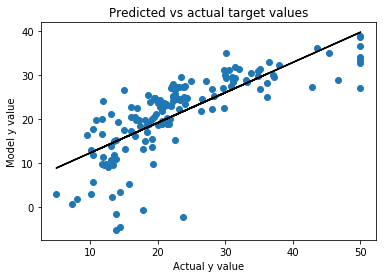

In [123]:
plt.scatter(y_test, svm_predictions)
z = np.polyfit(y_test, svm_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), "k-")

In [124]:
svm_model.score(X_test, y_test)

0.52301773573214949